# FISH FRY COUNTER

### Erru G. Torculas

The approach of this Fish Fry counter focuses on the image segmentation through the use of thresholding. It applies the OTSU Method to simplify the values automatically without the tedious process of manually fine-tuning the parameters.

Here's the summary of the accuracy results based on the average contour detection as well as standard deviation

| Actual | Avg Fry Count | Accuracy |   SD   |
| :----: | :-----------: | :------: | :----: |
| 100    | 97.765        | 97.77%   | 3.272  |
| 200    | 182.618       | 91.31%   | 8.484  |
| 300    | 294.78        | 98.26%   | 21.051 |
| 400    | 349.42        | 87.36%   | 29.363 |


## Importing Libraries

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Analysis

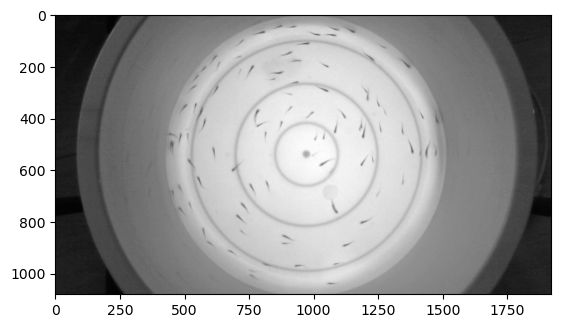

In [2]:
sample_img = cv.imread('./IMAGES/100/my_photo-6.jpg')
sample_img = cv.cvtColor(sample_img, cv.COLOR_BGR2GRAY)
plt.imshow(sample_img, cmap='gray')

In [3]:
def crop_img(img):
    img_centerX = img.shape[1] // 2
    img_centerY = img.shape[0] // 2

    # Initialize mask to use
    mask = np.zeros(img.shape, dtype=np.uint8)

    # Crop the image
    region_to_cut = cv.ellipse(mask, (img_centerX, img_centerY), (547, 547), 0, 0, 360, 255, -1)
    cropped_img = cv.bitwise_or(img, img, mask=region_to_cut)
    return cropped_img[:, img_centerX-600:img_centerX+600]

## Cropping and Filtering

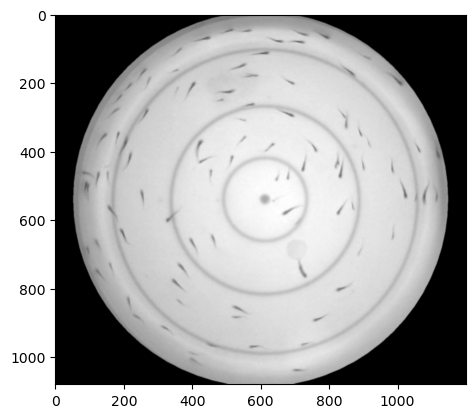

In [4]:
"""
    Crop the image to exclude the reflection of the fry in the side walls of the bin

    Gaussian blur was utilized in filtering the image to improve the binarization in the
    segmentation of the image. Noise filtering relatively improves the result of OTSU.
"""
sample_img_cropped = crop_img(sample_img)

sample_img_GaussianFilter = cv.GaussianBlur(sample_img_cropped,(5,5),0)
plt.imshow(sample_img_GaussianFilter, cmap='gray')

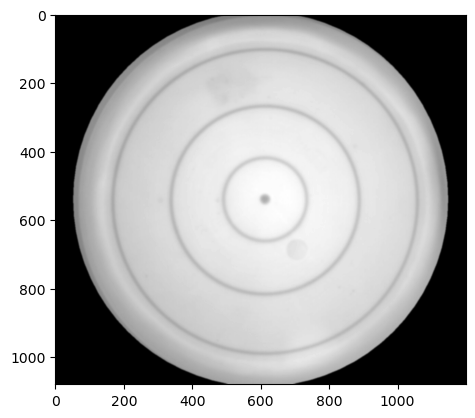

In [5]:
# Processing the background image
bg_img = cv.imread('./IMAGES/100/background.jpg')
bg_img = cv.cvtColor(bg_img, cv.COLOR_BGR2GRAY)
bg_img_cropped = crop_img(bg_img)

"""
    Crop the image to exclude the reflection of the fry in the side walls of the bin

    Applying the Gaussian filter in the background image to reduce the contour detection 
    of the circles (bowl). 
"""
# Gaussian filter in the background image
bg_img_GaussianFilter = cv.GaussianBlur(bg_img_cropped,(7,7),0)
plt.imshow(bg_img_GaussianFilter, cmap='gray')

## Layering Difference  of Foreground and Background Images

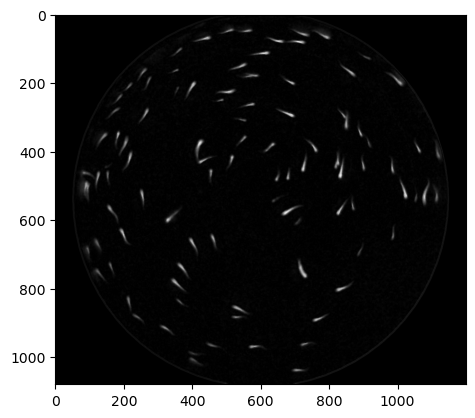

In [6]:
diff_img = cv.absdiff(sample_img_GaussianFilter, bg_img_GaussianFilter)
plt.imshow(diff_img, cmap='gray')

## Image Segmentation

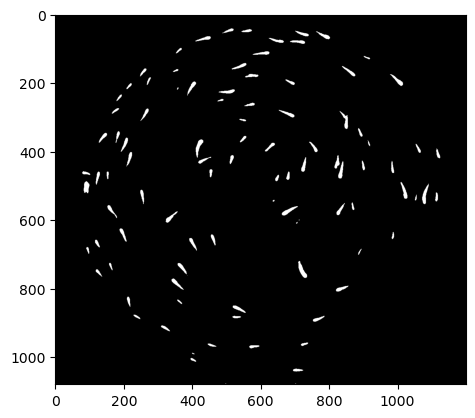

In [7]:
"""
    Threshold using OTSU Binarization.
    
    The OTSU method simplifies the thresholding process for determining the values automatically.
    Advantages of such an approach are precise real-time segmentation of underwater features and 
    proven performance in comparison with threshold segmentation methods.
"""
_, OTSU_thresh = cv.threshold(diff_img, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
plt.imshow(OTSU_thresh, cmap='gray')

In [8]:
def count_white_pixels(threshold):
    return np.count_nonzero(threshold == 255)

count_white_pixels(OTSU_thresh)

19667

## Contouring and Detection

99


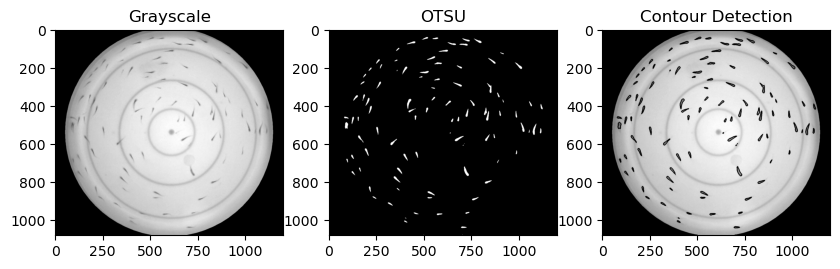

In [9]:
"""
    Dectection of Contours 
"""

contours, _ = cv.findContours(OTSU_thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

detection = cv.drawContours(sample_img_cropped, contours, -1, (0, 255, 0), 3)

print(len(contours))

# Create a figure with two subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Plot the first image in the first subplot
axs[0].imshow(crop_img(sample_img), cmap="gray")
axs[0].set_title('Grayscale')

# Plot the second image in the second subplot
axs[1].imshow(OTSU_thresh, cmap="gray")
axs[1].set_title('OTSU')

# Plot the second image in the second subplot
axs[2].imshow(detection, cmap = "gray")
axs[2].set_title('Contour Detection')

plt.show()

## Create a dataframe for training (100, 200, 300, and 400)

In [10]:
import os
import pandas as pd

In [11]:
# Path to the images (100)
path = './IMAGES/100/'
list_images_100 = [f for f in os.listdir(path) if f.startswith('my_photo')]
list_paths_100 = [path + f for f in list_images_100]

# Path to the images (200)
path = './IMAGES/200/'
list_images_200 = [f for f in os.listdir(path) if f.startswith('my_photo')]
list_paths_200 = [path + f for f in list_images_200]

# Path to the images (300)
path = './IMAGES/300/'
list_images_300 = [f for f in os.listdir(path) if f.startswith('my_photo')]
list_paths_300 = [path + f for f in list_images_300]

# Path to the images (400)
path = './IMAGES/400/'
list_images_400 = [f for f in os.listdir(path) if f.startswith('my_photo')]
list_paths_400 = [path + f for f in list_images_400]

In [12]:
df = pd.DataFrame(columns=['white_pixels', 'contours', 'label'])
os.makedirs('./exported_df', exist_ok=True)

# 100

In [13]:
# Image with 100
df_100 = df.copy()
for img_path in list_paths_100:
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_cropped = crop_img(img)
    img_GaussianFilter = cv.GaussianBlur(img_cropped,(5,5),0)
    
    bg_img = cv.imread('./IMAGES/100/background.jpg')
    bg_img = cv.cvtColor(bg_img, cv.COLOR_BGR2GRAY)
    bg_img_cropped = crop_img(bg_img)
    bg_img_GaussianFilter = cv.GaussianBlur(bg_img_cropped,(7,7),0)
    
    diff_img = cv.absdiff(img_GaussianFilter, bg_img_GaussianFilter)
    _, OTSU_thresh = cv.threshold(diff_img, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    white_pixels = count_white_pixels(OTSU_thresh)
    contours, hierarchy = cv.findContours(OTSU_thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    df_100 = pd.concat([df_100, pd.DataFrame({'white_pixels': [white_pixels], 'contours': [len(contours)],  'label': [100]})], ignore_index=True)

df_100.to_csv('./exported_df/df_100.csv', index=False)

In [14]:
df_100_avg = df_100['contours'].mean()
df_100_std = df_100['contours'].std()

df_100_avg, df_100_std

(97.76470588235294, 3.271624888608825)

In [15]:
print(f"Accuracy: {(df_100_avg/100)*100}%")

Accuracy: 97.76470588235294%


# 200

In [16]:
# Image with 200
df_200 = df.copy()
for img_path in list_paths_200:
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_cropped = crop_img(img)
    img_GaussianFilter = cv.GaussianBlur(img_cropped,(5,5),0)
    
    bg_img = cv.imread('./IMAGES/200/background.jpg')
    bg_img = cv.cvtColor(bg_img, cv.COLOR_BGR2GRAY)
    bg_img_cropped = crop_img(bg_img)
    bg_img_GaussianFilter = cv.GaussianBlur(bg_img_cropped,(7,7),0)
    
    
    diff_img = cv.absdiff(img_GaussianFilter, bg_img_GaussianFilter)
    _, OTSU_thresh = cv.threshold(diff_img, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    white_pixels = count_white_pixels(OTSU_thresh)
    contours, hierarchy = cv.findContours(OTSU_thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    df_200 = pd.concat([df_200, pd.DataFrame({'white_pixels': [white_pixels], 'contours': [len(contours)],  'label': [200]})], ignore_index=True)

df_200.to_csv('./exported_df/df_200.csv', index=False)

In [17]:
df_200_avg = df_200['contours'].mean()
df_200_std = df_200['contours'].std()

df_200_avg, df_200_std

(182.61818181818182, 8.484170247062748)

In [18]:
print(f"Accuracy: {(df_200_avg/200)*100}%")

Accuracy: 91.30909090909091%


# 300

In [19]:
# Image with 300
df_300 = df.copy()
for img_path in list_paths_300:
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_cropped = crop_img(img)
    img_GaussianFilter = cv.GaussianBlur(img_cropped,(5,5),0)
    
    bg_img = cv.imread('./IMAGES/300/background.jpg')
    bg_img = cv.cvtColor(bg_img, cv.COLOR_BGR2GRAY)
    bg_img_cropped = crop_img(bg_img)
    bg_img_GaussianFilter = cv.GaussianBlur(bg_img_cropped,(9,9),0)
    
    diff_img = cv.absdiff(img_GaussianFilter, bg_img_GaussianFilter)
    _, OTSU_thresh = cv.threshold(diff_img, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    white_pixels = count_white_pixels(OTSU_thresh)
    contours, hierarchy = cv.findContours(OTSU_thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    df_300 = pd.concat([df_300, pd.DataFrame({'white_pixels': [white_pixels], 'contours': [len(contours)], 'label': [300]})], ignore_index=True)

df_300.to_csv('./exported_df/df_300.csv', index=False)

In [20]:
df_300_avg = df_300['contours'].mean()
df_300_std = df_300['contours'].std()

df_300_avg, df_300_std

(294.78, 21.05123972305553)

In [21]:
print(f"Accuracy: {(df_300_avg/300)*100}%")

Accuracy: 98.25999999999999%


# 400

In [22]:
# Image with 400
df_400 = df.copy()
for img_path in list_paths_400:
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_cropped = crop_img(img)
    img_GaussianFilter = cv.GaussianBlur(img_cropped,(5,5),0)
    
    bg_img = cv.imread('./IMAGES/400/background.jpg')
    bg_img = cv.cvtColor(bg_img, cv.COLOR_BGR2GRAY)
    bg_img_cropped = crop_img(bg_img)
    bg_img_GaussianFilter = cv.GaussianBlur(bg_img_cropped,(9,9),0)
    
    diff_img = cv.absdiff(img_GaussianFilter, bg_img_GaussianFilter)
    _, OTSU_thresh = cv.threshold(diff_img, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    white_pixels = count_white_pixels(OTSU_thresh) 
    contours, hierarchy = cv.findContours(OTSU_thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    df_400 = pd.concat([df_400, pd.DataFrame({'white_pixels': [white_pixels], 'contours': [len(contours)],  'label': [400]})], ignore_index=True)

df_400.to_csv('./exported_df/df_400.csv', index=False)

In [23]:
df_400_avg = df_400['contours'].mean()
df_400_std = df_400['contours'].std()

df_400_avg, df_400_std

(349.42, 29.36267935280277)

In [24]:
print(f"Accuracy: {(df_400_avg/400)*100}%")

Accuracy: 87.355%
